In [1]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from transformers import RobertaTokenizer
import numpy as np
from scipy.special import softmax
import csv
import urllib.request

In [2]:
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"

tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)


In [3]:
text = ["I am angry", "I am happy"]
encoded_input = tokenizer(text, return_tensors='pt')
output = model(encoded_input['input_ids'], output_hidden_states=True)

In [4]:
from torch.utils.data import Dataset, DataLoader
import pandas as pd

# Load the review dataset
class ReviewLoader(Dataset):
    def __init__(self, file=None, transform=None, target_transform=None, tokenizer=None):
        self.file = pd.read_json(file)
        self.file = self.file
        self.file = tokenizer(list(self.file['X']), padding=True, truncation=True, max_length=512, return_tensors='pt')
        self.file = self.file['input_ids']
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.file)

    def __getitem__(self, idx):
        data = self.file[idx]
        return(data)

data = ReviewLoader(file = './task-examples/task-sentiment-amzbook.json', tokenizer=tokenizer)
review_dataloader = DataLoader(data, batch_size=10, shuffle=False)

In [5]:
from torch import nn

class EmbeddingModel(nn.Module):
    def __init__(self):
        super(EmbeddingModel, self).__init__()
        self.model = AutoModelForSequenceClassification.from_pretrained(MODEL)

    def forward(self, input):
        output = self.model(input, output_hidden_states=True)
        # print(output[1][24].shape)
        # return(output[1][24][0, 0])
        return output[1][-1][:, 0, :]

emb_model = EmbeddingModel()

In [6]:
import torch
# embs = []
# for data in review_dataloader:
#   # print(data.shape)
#   output = emb_model(data)
#   # print(output.shape)

#   with torch.no_grad():
#     out = embs.append(output.numpy())

embs = torch.empty(0,0)
for data in review_dataloader:
    if(len(embs) == 0):
      embs = emb_model(data)
    else:
      output = emb_model(data)
      with torch.no_grad():
        embs = torch.cat((embs, output), 0)

In [7]:
file = "./task-examples/task-sentiment-amzbook.json"
reviews = pd.read_json(file)
df_res = pd.DataFrame({ "testid": reviews['testid'], "X": reviews['X'], "emb": pd.Series(list(embs.detach().numpy()), dtype="object"), "Y": reviews['Y'], "pred": reviews['pred'], "conf": reviews['conf']})

In [8]:
df_res.to_json("task-examples/task-sentiment-amzbook-emb.json", orient='records')

In [ ]:
df_res['emb']

In [10]:
from sklearn.cluster import DBSCAN
from sklearn import cluster, datasets, mixture
from sklearn.manifold import TSNE, MDS

X_embedded = TSNE(n_components=2, learning_rate='auto', init='random').fit_transform(embs.detach().numpy())
X_MDS_embedded = MDS(n_components=2, max_iter=100, n_init=1).fit_transform(embs.detach().numpy())

In [12]:
df_res['emb_X'] = X_embedded[:, 0]
df_res['emb_Y'] = X_embedded[:, 1]

In [13]:
df_res[:5]

,testid,X,emb,Y,pred,conf,emb_X,emb_Y
0,930268,I found the history of Descartes bones and wha...,"[0.17859058, 0.52602214, -0.27808738, -0.64363...",1,1,0.949827,7.795757,-6.108063
1,977747,This book was a retelling of Cinderella from t...,"[-0.072779514, -0.12724139, -0.05457175, -0.37...",0,0,0.904762,4.705898,-6.104208
2,548360,This work juxtaposes the commercial trappings ...,"[0.2431745, 0.025579238, -0.2107528, -0.203716...",1,1,0.949827,7.276407,-5.515430
3,89892,This is the title that closes the chapter on S...,"[0.033378713, 0.25923732, -0.13415375, -0.3547...",0,1,0.644946,6.078758,-6.414030
4,909635,There is a lot of repetition from other books ...,"[0.03589915, 0.011446417, -0.030508025, -0.401...",1,0,0.904762,6.284438,-5.826723


In [23]:
# import matplotlib.pyplot as plt
# plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=df_res['Y'].tolist())
import plotly.express as px
fig = px.scatter(df_res, x="emb_X", y="emb_Y", color="Y", width=800, height=800,
                 size='conf', hover_data=['X'])

fig.update_layout(
    hoverlabel=dict(
        font_size=7,
        font_family="Rockwell",
    )
)

fig.show()

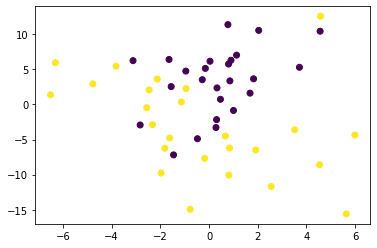

In [53]:
import matplotlib.pyplot as plt
plt.scatter(X_MDS_embedded[:, 0], X_MDS_embedded[:, 1], c=df_res['Y'].tolist())